In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import important libraries

In [2]:
!pip install dill

In [3]:
import pandas as pd
import numpy as np
import dill
from sklearn.utils import shuffle

# Read train data

In [4]:
X_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_train_preprocessed_under')
y_train = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_train_preprocessed_under')['target_event']

# Load test pipline

In [5]:
with open('/content/drive/MyDrive/Churn Prediction/test_pipeline.pkl', 'rb') as f:
    test_pipeline = dill.load(f)

# Read test data and transform


In [6]:
X_test = test_pipeline.transform(pd.read_parquet('/content/drive/MyDrive/Churn Prediction/X_test'))
y_test = pd.read_parquet('/content/drive/MyDrive/Churn Prediction/y_test')['target_event']

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

In [8]:
class BinaryClassificationEvaluation:
    def __init__(self, y_test, y_pred, y_pred_prob=None):
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_pred_prob = y_pred_prob

    def accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        return accuracy

    def classification_report(self):
        report = classification_report(self.y_test, self.y_pred)
        return report

    def precision_recall_f1(self):
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        return precision, recall, f1
    def roc_score(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for ROC curve evaluation.")
        auc_score = roc_auc_score(self.y_test, self.y_pred_prob)
        return auc_score

    def visualize_confusion_matrix(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Not Churn', 'Churn'],
                    yticklabels=['Not Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def roc_curve_visualization(self):
        auc_score = self.roc_score()
        print('=========================')
        print('||','ROC AUC Score:', auc_score.round(2),'||')
        print('=========================')
        fpr, tpr, _ = roc_curve(self.y_test, self.y_pred_prob)
        plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    def precision_recall_curve_plot(self):
        if self.y_pred_prob is None:
            raise ValueError("y_pred_prob must be provided for Precision-Recall curve evaluation.")

        precision, recall, _ = precision_recall_curve(self.y_test, self.y_pred_prob)
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

---
# ***AdaBoost Classifier Model***
---

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Initialize AdaBoost Classifier

In [68]:
ada_boost = AdaBoostClassifier(
    estimator=LogisticRegression(),
    algorithm='SAMME',
    random_state=42
)

# Initialize Stratifiedkfold

In [71]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Using grid search find best parameters and best splits using stratifiedkfold

In [102]:
params = {
    'n_estimators': [50, 55, 60],
    'learning_rate': [0.5, 0.7]
}

ada_search = GridSearchCV(
    estimator=ada_boost,
    param_grid=params,
    cv = kfold,
    scoring='f1',
    n_jobs=2
)

In [103]:
ada_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          estimator=LogisticRegression(),
                                          random_state=42),
             n_jobs=2,
             param_grid={'learning_rate': [0.5, 0.7],
                         'n_estimators': [50, 55, 60]},
             scoring='f1')

In [104]:
best_params = ada_search.best_params_
best_score = ada_search.best_score_

In [105]:
print('Best Parameters:', best_params)
print('Best Score:', best_score)

Best Parameters: {'learning_rate': 0.5, 'n_estimators': 55}
Best Score: 0.7864839557396442


# Create adaboost classifier evaluation object

In [106]:
ada_eval = BinaryClassificationEvaluation(y_test, ada_search.predict(X_test), ada_search.predict_proba(X_test)[:, 1])

# Evaluate model from different corner

In [107]:
print(ada_eval.classification_report())

              precision    recall  f1-score   support

           0       0.89      0.81      0.84     15296
           1       0.66      0.78      0.71      7226

    accuracy                           0.80     22522
   macro avg       0.77      0.79      0.78     22522
weighted avg       0.81      0.80      0.80     22522



In [108]:
precision, recall, f1 = ada_eval.precision_recall_f1()
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.6557129586623316
Recall: 0.7814835316911154
F1 Score: 0.7130950877636065


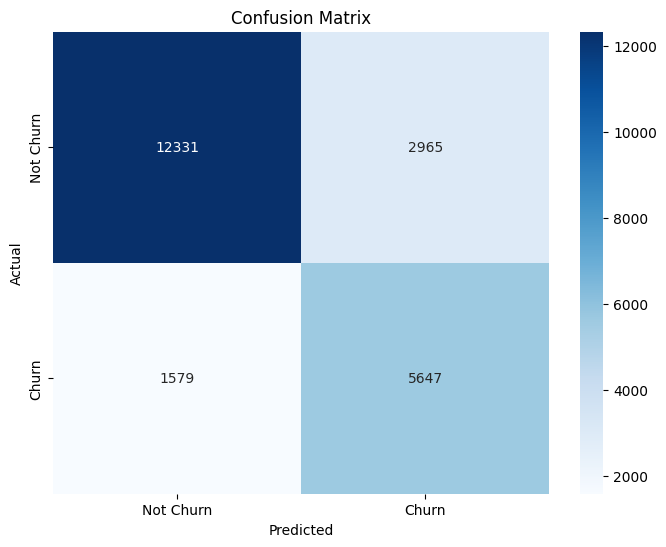

In [109]:
ada_eval.visualize_confusion_matrix()

|| ROC AUC Score: 0.87 ||


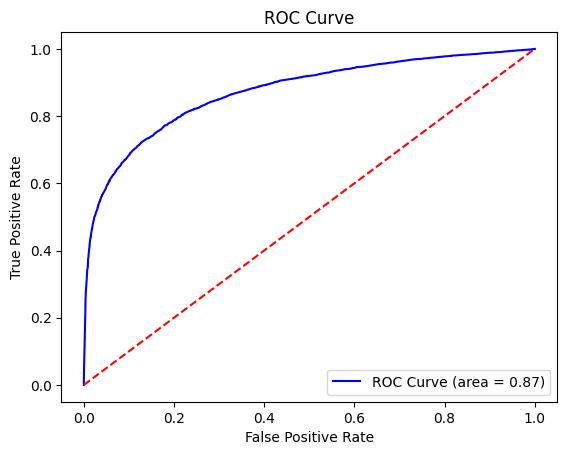

In [110]:
ada_eval.roc_curve_visualization()

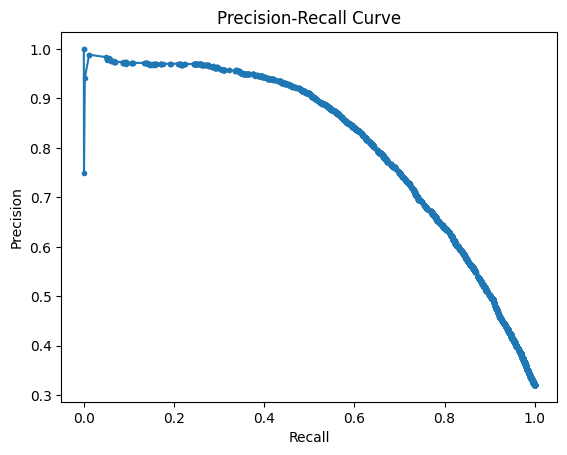

In [111]:
ada_eval.precision_recall_curve_plot()

# Try performance in different threshold

In [133]:
ada_theshold = 0.65
ada_y_pred = np.where(ada_search.predict_proba(X_test)[:, 1] >= ada_theshold, 1, 0)

In [134]:
ada_thesh_eval = BinaryClassificationEvaluation(y_test, ada_y_pred, ada_search.predict_proba(X_test)[:, 1])

In [135]:
print(ada_thesh_eval.classification_report())

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     15296
           1       0.82      0.62      0.71      7226

    accuracy                           0.84     22522
   macro avg       0.83      0.78      0.80     22522
weighted avg       0.83      0.84      0.83     22522



---
# ***XGBoost Classifier Model***
---

In [139]:
!pi install xgboost

/bin/bash: line 1: pi: command not found


In [140]:
import xgboost as xgb

# Initilize XGBoost model

In [164]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, max_depth = 3, gamma = 0.1, learning_rate = 0.2)

# Using grid search find best parameters and best splits using stratifiedkfold

In [171]:
param_grid_boost = {
    'n_estimators': [350, 400, 450]
}
boost_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid_boost,
                           scoring='f1',
                           n_jobs=2)

In [172]:
boost_search.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=0.1, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=2, param_grid={'n_estimators': [350, 400, 450]},
             scoring='f1')

In [175]:
best_params = boost_search.best_params_
print('Best Parameters:', best_params)

Best Parameters: {'n_estimators': 350}


In [176]:
best_boost = boost_search.best_estimator_

# Create object for evaluation XGBoost model

In [177]:
boost_eval = BinaryClassificationEvaluation(y_test, boost_search.predict(X_test), boost_search.predict_proba(X_test)[:, 1])

# Evaluate XGBoost model from different perspective

In [178]:
print(boost_eval.classification_report())

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     15296
           1       0.71      0.76      0.74      7226

    accuracy                           0.82     22522
   macro avg       0.80      0.81      0.80     22522
weighted avg       0.83      0.82      0.83     22522



In [180]:
precision, recall, f1 = boost_eval.precision_recall_f1()
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.7114015788792546
Recall: 0.7607251591475228
F1 Score: 0.7352370761720056


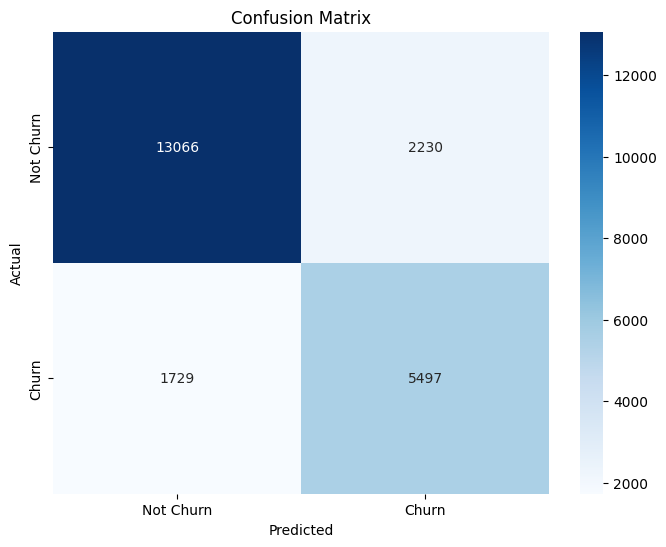

In [181]:
boost_eval.visualize_confusion_matrix()

|| ROC AUC Score: 0.88 ||


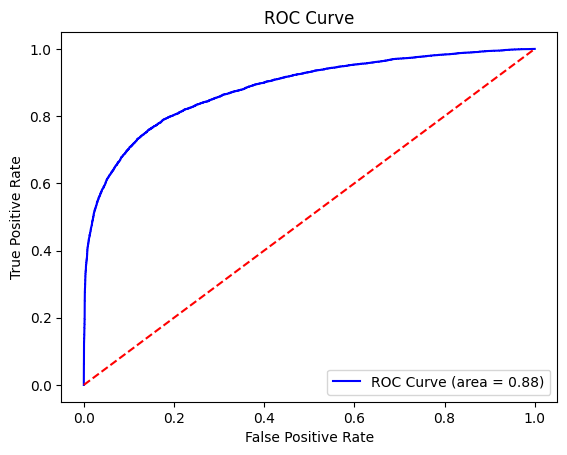

In [182]:
boost_eval.roc_curve_visualization()

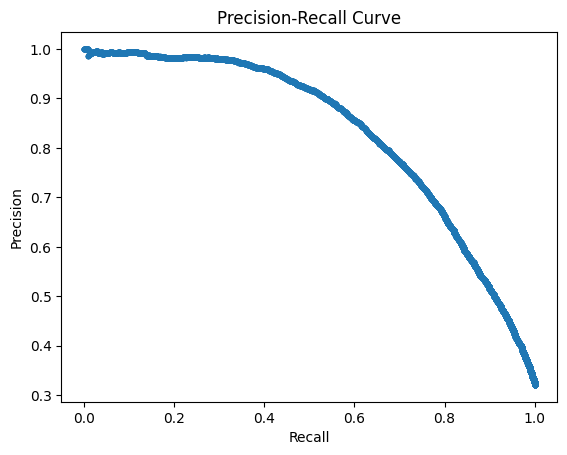

In [183]:
boost_eval.precision_recall_curve_plot()

|| ROC AUC Score: 0.88 ||


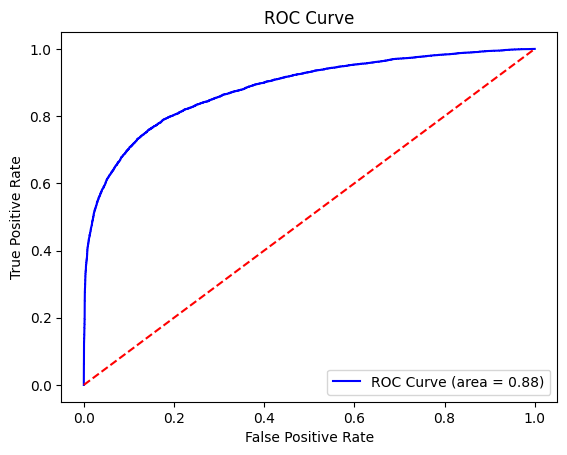

None


In [186]:
print(boost_eval.roc_curve_visualization())

# Try model with different threshold

In [230]:
boost_thresh = 0.58
boost_y_pred = np.where(boost_search.predict_proba(X_test)[:, 1] >= boost_thresh, 1, 0)

In [231]:
boost_thresh_eval = BinaryClassificationEvaluation(y_test, boost_y_pred, boost_search.predict_proba(X_test)[:, 1])

In [232]:
print(boost_thresh_eval.classification_report())

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     15296
           1       0.76      0.71      0.73      7226

    accuracy                           0.84     22522
   macro avg       0.81      0.80      0.81     22522
weighted avg       0.83      0.84      0.83     22522



In [233]:
precision, recall, f1 = boost_thresh_eval.precision_recall_f1()
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.761501929355892
Recall: 0.710074730141157
F1 Score: 0.7348897164136351


|| ROC AUC Score: 0.88 ||


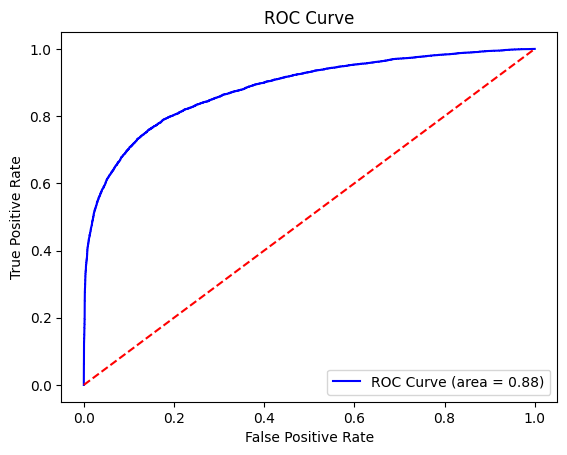

In [234]:
boost_thresh_eval.roc_curve_visualization()

# Create custom class for XGBoost Classifier

In [235]:
from sklearn.base import BaseEstimator, ClassifierMixin
import joblib

In [237]:
class XGBoostnCustom(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, threshold=0.58):
        self.n_estimators = n_estimators
        self.threshold = threshold
        self.model = None

    def fit(self, X, y):

        self.model = xgb.XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            max_depth=3,
            gamma=0.1,
            learning_rate=0.2,
            n_estimators=self.n_estimators
        )
        self.model.fit(X, y)

    def predict(self, X):

        if self.model is None:
            raise ValueError("Model must be fitted before making predictions.")

        y_proba = self.model.predict_proba(X)[:, 1]  # Probabilities for class 1
        y_pred = (y_proba >= self.threshold).astype(int)
        return y_pred

    def predict_proba(self, X):

        if self.model is None:
            raise ValueError("Model must be fitted before making predictions.")

        return self.model.predict_proba(X)

    def set_threshold(self, new_threshold):

        self.threshold = new_threshold

    def get_threshold(self):

        return self.threshold

    def save_model(self, file_path):

        with open(file_path, 'wb') as file:
            dill.dump(self, file)

    @staticmethod
    def load_model(file_path):
        with open(file_path, 'rb') as file:
            return dill.load(file)

In [236]:
best_params_boost = boost_search.best_params_

In [240]:
boost_thesh = XGBoostnCustom(
    n_estimators=best_params_boost['n_estimators'],
    threshold=0.58
)

In [241]:
boost_thesh.fit(X_train, y_train)

# Save model

In [242]:
boost_thesh.save_model('/content/drive/MyDrive/Churn Prediction/XGBoost_churn.pkl')